In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import librosa #library for processing audio
from librosa.display import specshow # Import the spectroscope function...

# Loading interactive visualisation...
from plot_lib import set_default
import matplotlib.pyplot as plt
import numpy as np

# Import Jupyter utilities for playing audio
from IPython.display import display, Audio

import torch.nn.functional as F
import torch

In [2]:
# ... in 2 cells 
set_default(figsize=(16, 8))

In [3]:
# Load audio
dataset = "../data/Windows20XP20Shutdown.wav"
x, sampling_rate = librosa.load(dataset)

In [4]:
# Compute the temporal length of x(t)
T = x.size / sampling_rate

print(
    f'x[k] has {x.size} samples',
    f'the sampling rate is {sampling_rate * 1e-3}kHz',
    f'x(t) is {T:.1f}s long'
    , sep='\n')

x[k] has 70641 samples
the sampling rate is 22.05kHz
x(t) is 3.2s long


In [5]:
# Create x(t) time span
dt = 1 / sampling_rate
t = np.r_[0:T:dt]
print(f'time span: {t.size} samples')

time span: 70641 samples


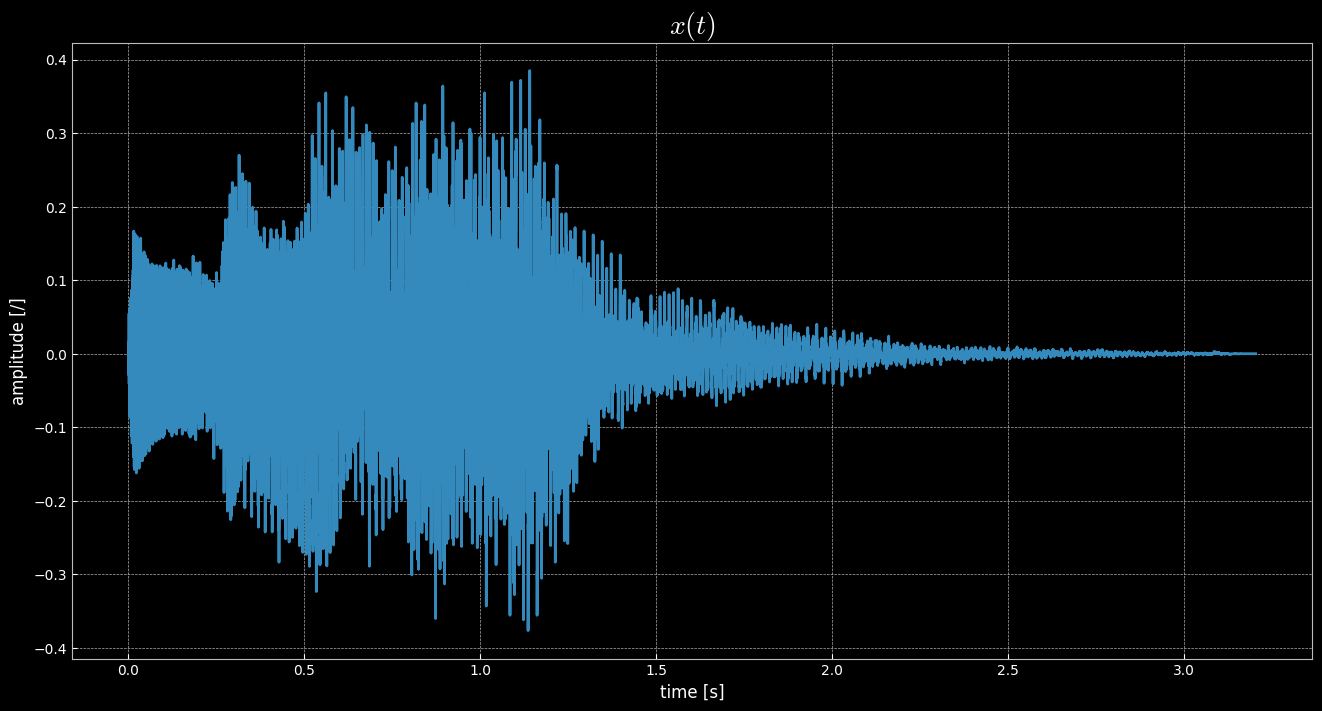

In [6]:
# Visualise x(t)
plt.figure()
plt.plot(t, x)
plt.xlabel('time [s]')
plt.ylabel('amplitude [/]')
plt.title(r'$x(t)$', size=20);

In [7]:
# Let's listen to x(t)
Audio(x, rate=sampling_rate)

In [8]:
# Compute Short-time Fourier transform (STFT) and convert the amplitude to dB
X = librosa.stft(x)
X_dB = librosa.amplitude_to_db(np.abs(X))

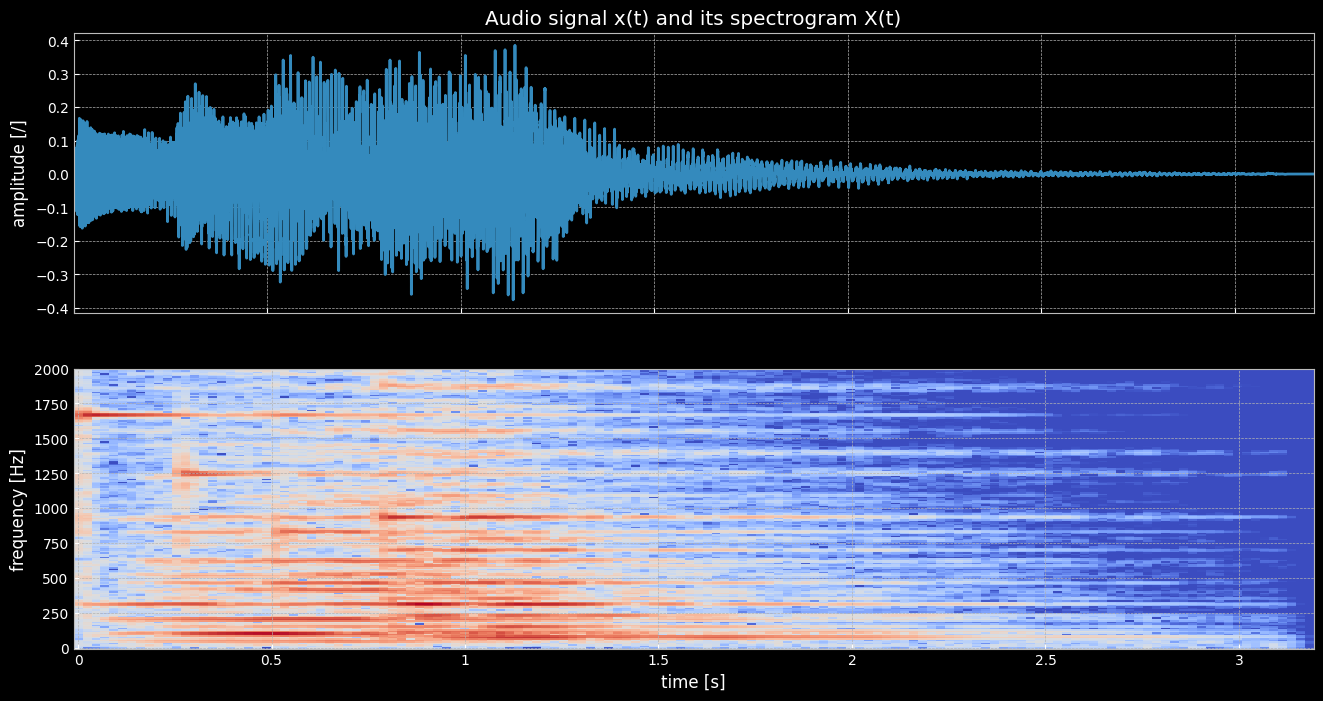

In [9]:
# ... and plot
plt.figure()
plt.subplot(2,1,1)
plt.plot(t, x)
plt.xlim([0, T])
plt.ylabel('amplitude [/]')
plt.title('Audio signal x(t) and its spectrogram X(t)')
plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.subplot(2,1,2)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.xlabel('time [s]')
plt.ylabel('frequency [Hz]')
plt.ylim(top=2000)
plt.grid(True)

In [10]:
# Manual recontruction of the melody:
# pick the melody frequencies/notes from the spectrogram above
Ab6 = 1661  # Hz
Eb6 = 1244  # Hz
Ab5 = 830   # Hz
Bb5 = 932   # Hz
TT = .4  # s
tt = np.r_[0:TT:dt]

# generate tones
A = {
    'a^(1)': np.sin(2 * np.pi * Ab6 * tt),
    'a^(2)': np.sin(2 * np.pi * Eb6 * tt),
    'a^(3)': np.sin(2 * np.pi * Ab5 * tt),
    'a^(4)': np.sin(2 * np.pi * Bb5 * tt),
}

# and concatenate them
xx = np.concatenate([a[1] for a in A.items()])

In [11]:
# Let's listen to the original and the reconstructed
display(Audio(x, rate=sampling_rate))
display(Audio(xx, rate=sampling_rate))

In [12]:
# Let's compute the STFT of the reconstruction
XX = librosa.stft(xx)
XX_dB = librosa.amplitude_to_db(np.abs(XX))

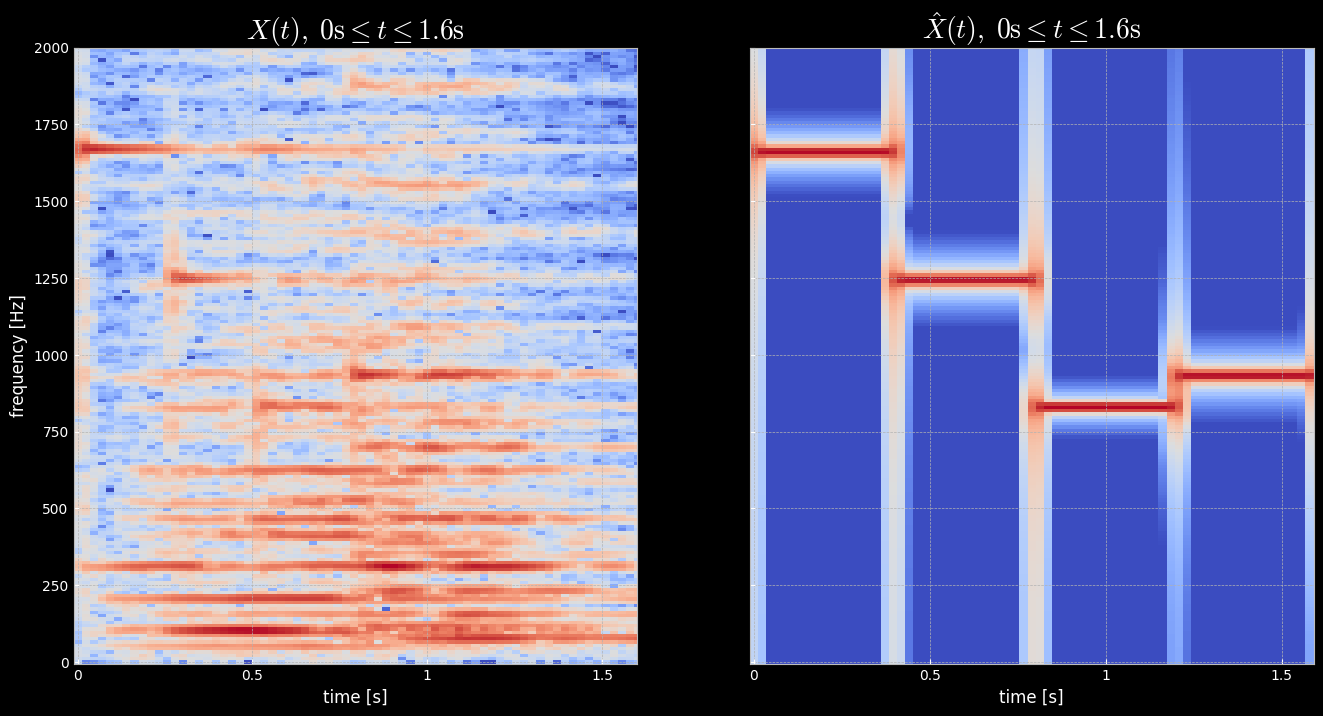

In [13]:
# ... and plot both X(t) and XX(t)
plt.figure()
t_string = r'$0\mathrm{s} \leq t \leq 1.6\mathrm{s}$'

plt.subplot(1,2,1)
specshow(X_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.ylim(ymax=2000)
plt.ylabel('frequency [Hz]')
plt.xlabel('time [s]')
plt.grid(True)
plt.xlim(right=1.6)
plt.title(r'$X(t),\; $' + t_string, size=20)

plt.subplot(1,2,2)
specshow(XX_dB, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.setp(plt.gca().get_yticklabels(), visible=False)
plt.xlabel('time [s]')
plt.ylim(top=2000)
plt.ylabel('')
plt.grid(True)
plt.title(r'$\hat X(t),\; $' + t_string, size=20);

Text(0.5, 0, 'samples [/]')

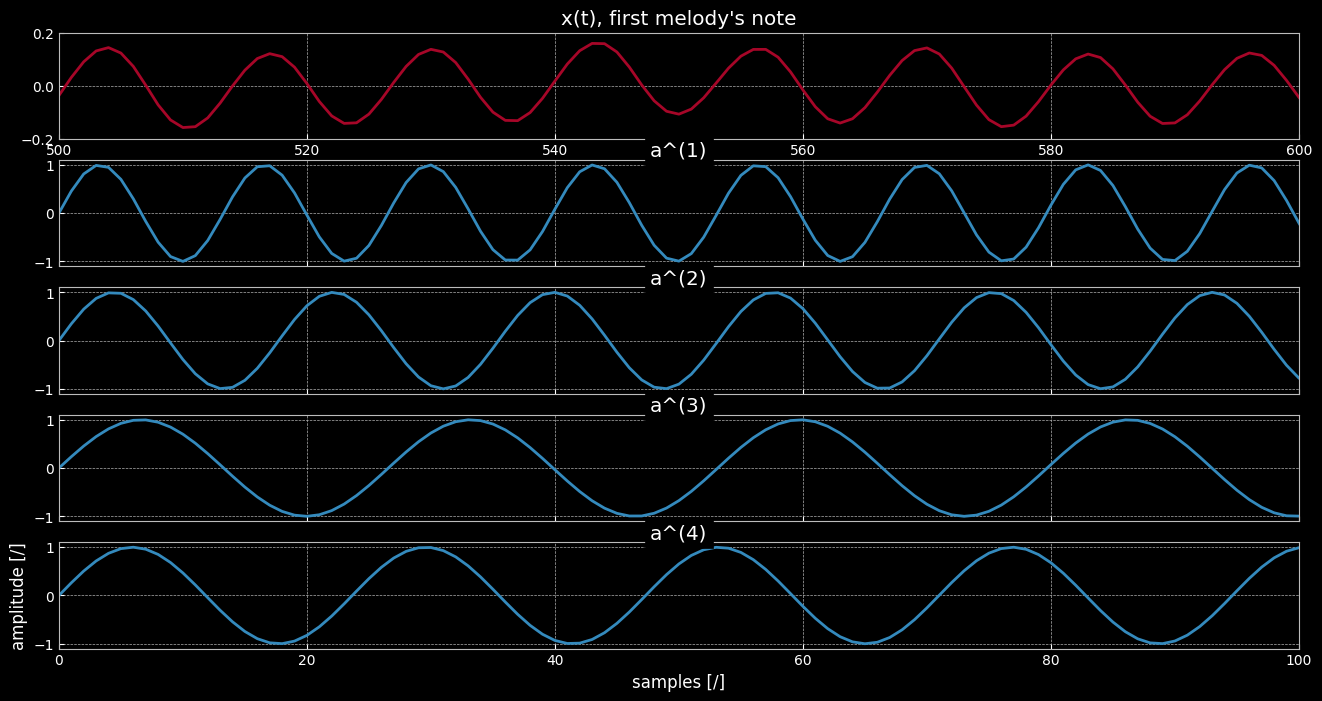

In [14]:
# What about in the time domain? Let's plot x(t) and a^(i)(t)
plt.figure()
plt.subplot(5, 1, 1)
plt.title('x(t), first melody\'s note')
plt.plot(x, 'C1')
plt.xlim([500, 600])
plt.ylim([-.2, .2])
i = 2
for a in A.items():
    plt.subplot(5, 1, i)
    i += 1
    plt.plot(a[1])
    plt.xlim([0, 100])
    plt.title(a[0], verticalalignment='top', backgroundcolor='black')
    if i < 6: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)

plt.ylabel('amplitude [/]')
plt.xlabel('samples [/]')

/var/folders/b9/jjp98g8j2mbcn65j0fgl0dzw0000gp/T/ipykernel_45123/3617240879.py:13: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/Convolution.cpp:1009.)
  out = F.conv1d(inp, wei, padding='same')


Text(0.5, 0, 'time [s]')

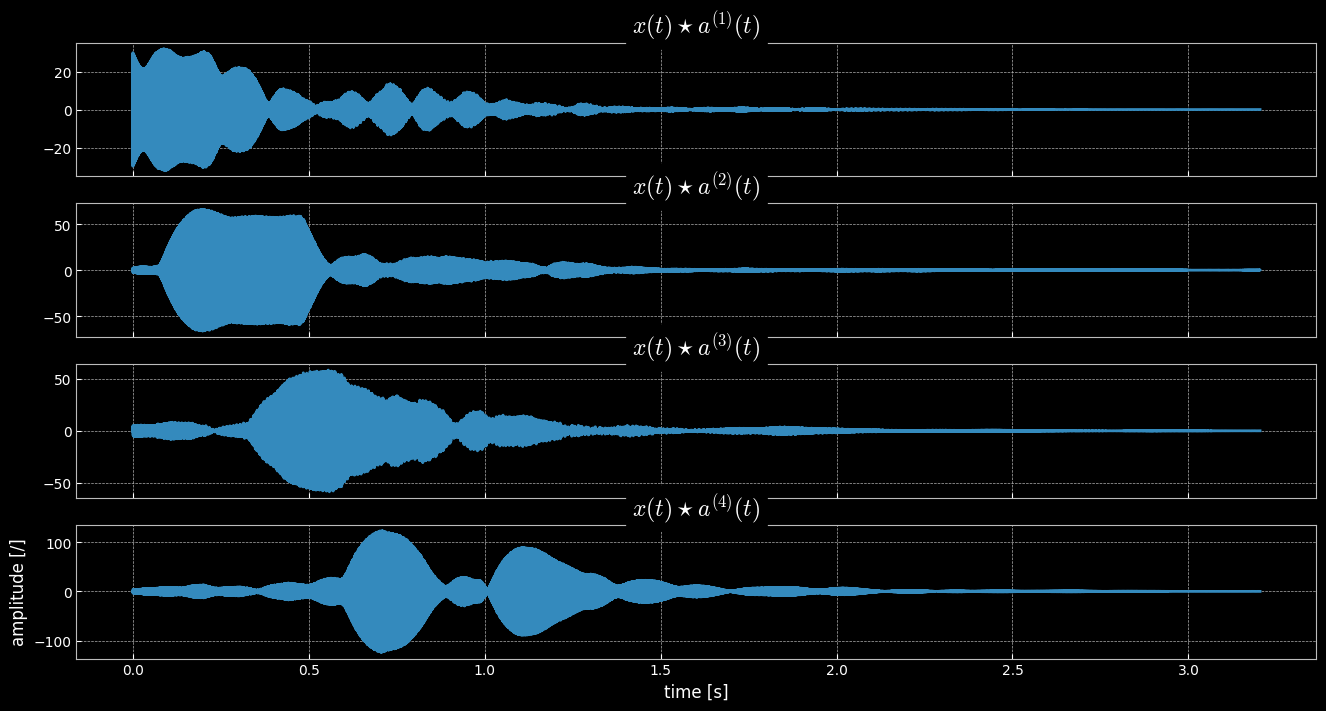

In [15]:
# Finally, let's convolve each tune a^(i) with x(t)
plt.figure()
convs = list()
n = 1
for a in A.items():
    plt.subplot(4, 1, n)
    plt.title(rf'$x(t) \star a^{{({n})}}(t)$', backgroundcolor='black', verticalalignment='top', size=17)
    n += 1
    # convs.append(np.convolve(x, a[1], mode='same'))

    inp = torch.reshape(torch.from_numpy(x), (1, 1, x.size)).float()
    wei = torch.reshape(torch.from_numpy(a[1]), (1, 1, a[1].size)).float()
    out = F.conv1d(inp, wei, padding='same')
    out = out.flatten().numpy()
    convs.append(out)
    plt.plot(t, convs[-1])
    if n < 5: 
        plt.setp(plt.gca().get_xticklabels(), visible=False)
plt.ylabel('amplitude [/]')
plt.xlabel('time [s]')

In [16]:
# Finally, let's listen to these convolutions!
for c in convs:
    display(Audio(c, rate=sampling_rate))